In [1]:
import os
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
from torch.utils.data import DataLoader

DATA = 'ravdess_LogMFB_Energy_Pitch_NCCF'
ROOT = './Dataset/{}'.format(DATA)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
MODEL_PATH = './model/{}_DANN_1DCNN-GRU_CV'.format(DATA)
NPARR_PATH = './array/{}_DANN_1DCNN-GRU_CV accuracies.npz'.format(DATA)

In [2]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for Ravdess

In [3]:
class RavdessDataset2(object):
    """
        Create a Dataset for RAVDESS. Each item is a tuple of the form:
        (feature, emotion, speaker)
    """ 
    
    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    _emotions = { '01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7 }
 
    _speaker = {'0'+ str(i+1): i for i in range(24) if i< 9}
    _speaker.update({str(i+1): i for i in range(24) if i>= 9})

    
    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.allActors = ['0'+ str(i+1) for i in range(24)if i<9] + [str(i+1) for i in range(24)if i>=9]
        
        self.cv = { 0:  (['01','02'],['03','04']),
                    1:  (['03','04'],['05','06']),
                    2:  (['05','06'],['07','08']),
                    3:  (['07','08'],['09','10']),
                    4:  (['09','10'],['11','12']),
                    5:  (['11','12'],['13','14']),
                    6:  (['13','14'],['15','16']),
                    7:  (['15','16'],['17','18']),
                    8:  (['17','18'],['19','20']),
                    9:  (['19','20'],['21','22']),
                    10: (['21','22'],['23','24']),
                    11: (['23','24'],['01','02'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files: 
                
                if split == 'train':
                    if file[-5:-3] in [x for x in self.allActors if x not in (self.cv[cv_index][0]+ self.cv[cv_index][1])]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'validate':
                    if file[-5:-3] in self.cv[cv_index][0]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'test':
                    if file[-5:-3] in self.cv[cv_index][1]:
                        self.data.append([file[-5:-3],file[6:8],file])
                else:
                    print("Error: Split can only be train, validate or test!")

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        file_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        feature = torch.load(file_name )
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (feature,emotion,speaker)

        return sample

In [4]:
# # Initialize RavdessDataset
# ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = 4,split= 'train')
# ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = 4,split= 'test')
# ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# ravdess_dataset_train.df

In [5]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 16
# VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
# TEST_BATCH_SIZE = len(ravdess_dataset_test)
# ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)

In [6]:
# next(iter(ravdess_train_loader))

## 2. Network Architectures and Helper Functions

### 2.1 Network Architectures

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=43, out_channels=32, kernel_size=10, stride =2 ,padding=0),  
            nn.PReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride =2 ,padding=0), 
            nn.PReLU(),      
        )
        
        self.GRU = nn.GRU(input_size= 32, hidden_size = 32 ,batch_first = True) 
        
        self.FC = nn.Sequential(
            nn.Linear(in_features = 32, out_features = 32),
            nn.PReLU(), 
        )
        
        self.FC2 = nn.Linear(in_features = 96, out_features = 32)
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        #print("conv shape: {}".format(x.shape))        # batch_size, c_out, time
        x = x.permute(0,2,1)
        #print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, time, c_out
        output, hn = self.GRU(x)
        #print("GRU output shape: {}".format(output.shape))  # batch_size, time, c_out   
        x = self.FC(output)
        #print("FC shape: {}".format(x.shape)) # 16 x 220 x 32
        mean = torch.mean(x,1)
        stdev = torch.std(x,1)
        tmax = torch.max(x,1)[0]
        x = torch.cat((mean,stdev,tmax),1)
        #print("Statistical pooling shape: {}".format(x.shape)) # 16 x 96
        x = self.FC2(x)
        #print("FC2 shape: {}".format(x.shape))
        
        return x


In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            
            nn.Linear(32, 32),
            nn.PReLU(),
            nn.Linear(32, 10),
            nn.PReLU(),
            nn.Linear(10, 8),

        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


In [9]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(32, 32),
            nn.PReLU(),
            nn.Linear(32, 10),
            nn.PReLU(),
            nn.Linear(10, 24),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 2.2 Helper Functions

In [10]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

In [11]:
def save_accuracies_and_losses(PATH):
    np.savez(PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies,
         spkClassLoss = fold_speaker_class_losses,
         spkTrain_acc = fold_speaker_training_accuracies,
         spkValidate_acc = fold_speaker_validating_accuracies,
        
    )

## 4. Model Training

In [12]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

FOLDS = 12
EPOCHS = 100

############### To comment this section out if disrupted #############
fold_emotion_class_losses = np.zeros((FOLDS,EPOCHS))
fold_emotion_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_emotion_validating_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_class_losses = np.zeros((FOLDS,EPOCHS))
fold_speaker_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_validating_accuracies = np.zeros((FOLDS,EPOCHS))


######### To uncomment if trying to continue disrupted training ######
# fold_emotion_class_losses, fold_emotion_training_accuracies, fold_emotion_validating_accuracies， fold_speaker_class_losses，fold_speaker_training_accuracies，fold_speaker_validating_accuracies= np.load(NPARR_PATH)

###################################################################

# 12-fold cross validation
for fold in range(0,FOLDS):

    # Selecting CPU or GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE).train()

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    # DANN should be trained on labelled data from the source domain and unlabelled data from the target domain
    TRAIN_BATCH_SIZE = 32
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    epoch_speaker_class_losses = []
    speaker_training_accuracies = []
    speaker_validating_accuracies = []

    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        completed_start_steps = epoch * len(ravdess_train_loader)
        total_steps = EPOCHS * len(ravdess_train_loader)

        batch_emotion_class_losses = []
        batch_speaker_class_losses = []


        for batch_idx, (feature, emotion, speaker) in enumerate(ravdess_train_loader):

            # Assigned to DEVICE. 
            features, emotion, speaker = feature.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE)


            # Calculate speaker and emotion classification prediction 
            conv_features = encoder(features)
            emotion_preds = emotion_classifier(conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)
            speaker_preds = speaker_classifier(conv_features)
            speaker_class_loss = cross_entropy_loss(speaker_preds, speaker)

            # Calculate total loss
            total_loss = 0.5* emotion_class_loss - 0.5 * speaker_class_loss

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)
            speaker_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            total_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            speaker_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss.detach())
            batch_speaker_class_losses.append(speaker_class_loss.detach())


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()
        speaker_classifier.eval()

        emotion_training_correct, emotion_validating_correct, speaker_training_correct, speaker_validating_correct = 0 , 0 , 0 , 0

        with torch.no_grad():

        # 1. Training Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
            speaker_training_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          speaker_training_accuracy = speaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          speaker_training_accuracies.append(speaker_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
          print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(speaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100))

        # 2. Validating Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
            speaker_validating_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          speaker_validating_accuracy = speaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          speaker_validating_accuracies.append(speaker_validating_accuracy)
          print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
          print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(speaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()
        speaker_classifier.train()


        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        epoch_speaker_class_loss = torch.mean(torch.stack(batch_speaker_class_losses), dim=0)
        epoch_speaker_class_losses.append(epoch_speaker_class_loss)
        
    fold_emotion_class_losses[fold] = epoch_emotion_class_losses
    fold_emotion_training_accuracies[fold] = emotion_training_accuracies
    fold_emotion_validating_accuracies[fold] = emotion_validating_accuracies
    fold_speaker_class_losses[fold] = epoch_speaker_class_losses
    fold_speaker_training_accuracies[fold] = speaker_training_accuracies
    fold_speaker_validating_accuracies[fold] = speaker_validating_accuracies
    
    save_accuracies_and_losses(NPARR_PATH)
    
    
    



Current Fold: 0 | Epoch: 0


Emotion Training Correct: 228/1184 
Emotion Training Accuracy: 19.25676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 1


Emotion Training Correct: 266/1184 
Emotion Training Accuracy: 22.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 3


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 4


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 5


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 6


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 7


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 8


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 9


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 10


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 11


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 12


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 13


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 14


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 15


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 16


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 17


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 18


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 19


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 20


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 21


Emotion Training Correct: 322/1184 
Emotion Training Accuracy: 27.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 22


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 23


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 24


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 25


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 26


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 27


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 28


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 29


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 30


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 31


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 32


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 33


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 34


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 35


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 36


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 37


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 38


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 39


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 40


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 41


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 42


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 43


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 44


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 45


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 46


Emotion Training Correct: 300/1184 
Emotion Training Accuracy: 25.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 47


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 48


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 49


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 50


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 51


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 52


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 53


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 54


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 55


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 56


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 57


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 58


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 59


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 60


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 61


Emotion Training Correct: 415/1184 
Emotion Training Accuracy: 35.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 62


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 63


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 64


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 65


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 66


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 67


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 68


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 69


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 70


Emotion Training Correct: 330/1184 
Emotion Training Accuracy: 27.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 71


Emotion Training Correct: 309/1184 
Emotion Training Accuracy: 26.09797%
Speaker Training Correct: 1/1184 
Speaker Training Accuracy: 0.08446%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 0 | Epoch: 72


Emotion Training Correct: 301/1184 
Emotion Training Accuracy: 25.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 73


Emotion Training Correct: 328/1184 
Emotion Training Accuracy: 27.70270%
Speaker Training Correct: 2/1184 
Speaker Training Accuracy: 0.16892%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 0 | Epoch: 74


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 75


Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 76


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 77


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 78


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 79


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 80


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 81


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 82


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 0 | Epoch: 83


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 84


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 85


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 86


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 87


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 88


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 89


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 90


Emotion Training Correct: 306/1184 
Emotion Training Accuracy: 25.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 91


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 92


Emotion Training Correct: 322/1184 
Emotion Training Accuracy: 27.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 93


Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 94


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 95


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 96


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 97


Emotion Training Correct: 335/1184 
Emotion Training Accuracy: 28.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 98


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 0 | Epoch: 99


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 0


Emotion Training Correct: 303/1184 
Emotion Training Accuracy: 25.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 1 | Epoch: 1


Emotion Training Correct: 289/1184 
Emotion Training Accuracy: 24.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 2


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 3


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 4


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 5


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 6


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 7


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 8


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 9


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 10


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 11


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 12


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 13


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 14


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 15


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 16


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 17


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 18


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 19


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 20


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 21


Emotion Training Correct: 317/1184 
Emotion Training Accuracy: 26.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 22


Emotion Training Correct: 313/1184 
Emotion Training Accuracy: 26.43581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 23


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 24


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 25


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 26


Emotion Training Correct: 332/1184 
Emotion Training Accuracy: 28.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 27


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 28


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 29


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 30


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 31


Emotion Training Correct: 288/1184 
Emotion Training Accuracy: 24.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 18/120 
Emotion Validating Accuracy: 15.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 32


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 33


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 34


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 35


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 36


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 37


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 38


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 39


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 40


Emotion Training Correct: 326/1184 
Emotion Training Accuracy: 27.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 41


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 42


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 43


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 44


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 45


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 46


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 47


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 48


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 49


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 50


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 51


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 52


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 53


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 54


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 55


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 56


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 57


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 58


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 59


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 60


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 61


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 62


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 63


Emotion Training Correct: 415/1184 
Emotion Training Accuracy: 35.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 64


Emotion Training Correct: 428/1184 
Emotion Training Accuracy: 36.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 65


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 66


Emotion Training Correct: 415/1184 
Emotion Training Accuracy: 35.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 67


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 68


Emotion Training Correct: 415/1184 
Emotion Training Accuracy: 35.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 69


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 70


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 71


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 72


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 73


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 74


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 75


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 76


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 77


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 78


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 79


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 80


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 81


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 82


Emotion Training Correct: 418/1184 
Emotion Training Accuracy: 35.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 83


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 84


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 85


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 86


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 87


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 88


Emotion Training Correct: 422/1184 
Emotion Training Accuracy: 35.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 89


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 90


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 91


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 92


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 93


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 94


Emotion Training Correct: 340/1184 
Emotion Training Accuracy: 28.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 95


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 96


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 97


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 98


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 99


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 0


Emotion Training Correct: 158/1184 
Emotion Training Accuracy: 13.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 16/120 
Emotion Validating Accuracy: 13.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 1


Emotion Training Correct: 280/1184 
Emotion Training Accuracy: 23.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 2


Emotion Training Correct: 292/1184 
Emotion Training Accuracy: 24.66216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 3


Emotion Training Correct: 300/1184 
Emotion Training Accuracy: 25.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 4


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 5


Emotion Training Correct: 325/1184 
Emotion Training Accuracy: 27.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 6


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 7


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 8


Emotion Training Correct: 285/1184 
Emotion Training Accuracy: 24.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 9


Emotion Training Correct: 335/1184 
Emotion Training Accuracy: 28.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 10


Emotion Training Correct: 332/1184 
Emotion Training Accuracy: 28.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 11


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 12


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 13


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 14


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 15


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 16


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 17


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 18


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 19


Emotion Training Correct: 335/1184 
Emotion Training Accuracy: 28.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 20


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 21


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 22


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 23


Emotion Training Correct: 325/1184 
Emotion Training Accuracy: 27.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 24


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 25


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 26


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 27


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 28


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 29


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 30


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 31


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 32


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 33


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 34


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 35


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 36


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 37


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 38


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 39


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 40


Emotion Training Correct: 298/1184 
Emotion Training Accuracy: 25.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 41


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 42


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 43


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 44


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 45


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 46


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 47


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 48


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 49


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 50


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 51


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 52


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 53


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 54


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 55


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 56


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 57


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 58


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 59


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 60


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 61


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 62


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 63


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 64


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 65


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 66


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 67


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 68


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 69


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 70


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 71


Emotion Training Correct: 340/1184 
Emotion Training Accuracy: 28.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 72


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 73


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 74


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 75


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 76


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 77


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 78


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 79


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 80


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 81


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 82


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 83


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 84


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 85


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 86


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 87


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 88


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 89


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 90


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 91


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 92


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 93


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 94


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 95


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 96


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 97


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 98


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 99


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 3 | Epoch: 0


Emotion Training Correct: 226/1184 
Emotion Training Accuracy: 19.08784%
Speaker Training Correct: 60/1184 
Speaker Training Accuracy: 5.06757%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 1


Emotion Training Correct: 263/1184 
Emotion Training Accuracy: 22.21284%
Speaker Training Correct: 22/1184 
Speaker Training Accuracy: 1.85811%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 2


Emotion Training Correct: 236/1184 
Emotion Training Accuracy: 19.93243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 17/120 
Emotion Validating Accuracy: 14.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 3


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 4


Emotion Training Correct: 327/1184 
Emotion Training Accuracy: 27.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 5


Emotion Training Correct: 317/1184 
Emotion Training Accuracy: 26.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 6


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 7


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 8


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 9


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 10


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 11


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 12


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 13


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 14


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 15


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 16


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 17


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 18


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 19


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 20


Emotion Training Correct: 294/1184 
Emotion Training Accuracy: 24.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 21


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 22


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 23


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 24


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 25


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 26


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 27


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 28


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 29


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 30


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 31


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 32


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 33


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 34


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 35


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 36


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 37


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 38


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 39


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 40


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 41


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 42


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 43


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 44


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 45


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 46


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 47


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 48


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 49


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 50


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 51


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 52


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 53


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 54


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 55


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 56


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 57


Emotion Training Correct: 340/1184 
Emotion Training Accuracy: 28.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 58


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 59


Emotion Training Correct: 300/1184 
Emotion Training Accuracy: 25.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 60


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 61


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 62


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 63


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 64


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 65


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 66


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 67


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 68


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 69


Emotion Training Correct: 427/1184 
Emotion Training Accuracy: 36.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 70


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 71


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 72


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 73


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 74


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 75


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 76


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 77


Emotion Training Correct: 427/1184 
Emotion Training Accuracy: 36.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 78


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 79


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 80


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 81


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 82


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 83


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 84


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 85


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 86


Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 87


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 88


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 89


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 90


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 91


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 92


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 93


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 94


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 95


Emotion Training Correct: 428/1184 
Emotion Training Accuracy: 36.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 96


Emotion Training Correct: 329/1184 
Emotion Training Accuracy: 27.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 97


Emotion Training Correct: 431/1184 
Emotion Training Accuracy: 36.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 98


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 99


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 0


Emotion Training Correct: 210/1184 
Emotion Training Accuracy: 17.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 4 | Epoch: 1


Emotion Training Correct: 296/1184 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2


Emotion Training Correct: 322/1184 
Emotion Training Accuracy: 27.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 3


Emotion Training Correct: 313/1184 
Emotion Training Accuracy: 26.43581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 20/120 
Emotion Validating Accuracy: 16.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 4


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 5


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 6


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 7


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 8


Emotion Training Correct: 316/1184 
Emotion Training Accuracy: 26.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 9


Emotion Training Correct: 338/1184 
Emotion Training Accuracy: 28.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 10


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 11


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 12


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 13


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 14


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 15


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 16


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 17


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 18


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 19


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 20


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 21


Emotion Training Correct: 311/1184 
Emotion Training Accuracy: 26.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 22


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 23


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 24


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 25


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 26


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 27


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 28


Emotion Training Correct: 296/1184 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 29


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 30


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 31


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 32


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 33


Emotion Training Correct: 418/1184 
Emotion Training Accuracy: 35.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 34


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 35


Emotion Training Correct: 418/1184 
Emotion Training Accuracy: 35.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 36


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 37


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 38


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 39


Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 40


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 41


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 42


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 43


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 44


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 45


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 46


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 47


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 48


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 49


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 50


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 51


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 52


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 53


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 54


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 55


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 56


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 57


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 58


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 59


Emotion Training Correct: 327/1184 
Emotion Training Accuracy: 27.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 60


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 61


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 62


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 63


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 64


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 65


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 66


Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 67


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 68


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 69


Emotion Training Correct: 317/1184 
Emotion Training Accuracy: 26.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 70


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 71


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 72


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 73


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 74


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 75


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 76


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 77


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 78


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 79


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 80


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 81


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 82


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 83


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 84


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 85


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 86


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 87


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 88


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 89


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 90


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 91


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 92


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 19/120 
Emotion Validating Accuracy: 15.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 93


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 94


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 95


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 96


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 97


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 98


Emotion Training Correct: 323/1184 
Emotion Training Accuracy: 27.28041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 99


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 0


Emotion Training Correct: 157/1184 
Emotion Training Accuracy: 13.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 16/120 
Emotion Validating Accuracy: 13.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 5 | Epoch: 1


Emotion Training Correct: 259/1184 
Emotion Training Accuracy: 21.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 2


Emotion Training Correct: 245/1184 
Emotion Training Accuracy: 20.69257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 3


Emotion Training Correct: 263/1184 
Emotion Training Accuracy: 22.21284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 4


Emotion Training Correct: 261/1184 
Emotion Training Accuracy: 22.04392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 5


Emotion Training Correct: 312/1184 
Emotion Training Accuracy: 26.35135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 6


Emotion Training Correct: 301/1184 
Emotion Training Accuracy: 25.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 7


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 8


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 9


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 10


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 11


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 12


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 13


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 14


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 15


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 16


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 17


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 18


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 19


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 20


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 21


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 22


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 23


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 24


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 25


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 26


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 27


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 28


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 29


Emotion Training Correct: 319/1184 
Emotion Training Accuracy: 26.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 30


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 31


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 32


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 33


Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 34


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 35


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 36


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 37


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 38


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 39


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 40


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 41


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 42


Emotion Training Correct: 330/1184 
Emotion Training Accuracy: 27.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 43


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 44


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 45


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 46


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 47


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 48


Emotion Training Correct: 275/1184 
Emotion Training Accuracy: 23.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 49


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 50


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 51


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 52


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 53


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 54


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 55


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 56


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 57


Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 58


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 59


Emotion Training Correct: 289/1184 
Emotion Training Accuracy: 24.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 60


Emotion Training Correct: 316/1184 
Emotion Training Accuracy: 26.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 61


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 62


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 63


Emotion Training Correct: 337/1184 
Emotion Training Accuracy: 28.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 64


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 65


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 66


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 67


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 68


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 69


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 70


Emotion Training Correct: 329/1184 
Emotion Training Accuracy: 27.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 71


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 72


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 73


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 74


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 75


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 76


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 77


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 78


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 79


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 80


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 81


Emotion Training Correct: 332/1184 
Emotion Training Accuracy: 28.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 82


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 83


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 84


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 85


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 86


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 87


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 88


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 89


Emotion Training Correct: 319/1184 
Emotion Training Accuracy: 26.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 90


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 91


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 92


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 93


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 94


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 95


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 96


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 97


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 98


Emotion Training Correct: 325/1184 
Emotion Training Accuracy: 27.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 5 | Epoch: 99


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 6 | Epoch: 0


Emotion Training Correct: 260/1184 
Emotion Training Accuracy: 21.95946%
Speaker Training Correct: 59/1184 
Speaker Training Accuracy: 4.98311%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 6 | Epoch: 1


Emotion Training Correct: 240/1184 
Emotion Training Accuracy: 20.27027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 2


Emotion Training Correct: 292/1184 
Emotion Training Accuracy: 24.66216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 3


Emotion Training Correct: 317/1184 
Emotion Training Accuracy: 26.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 4


Emotion Training Correct: 326/1184 
Emotion Training Accuracy: 27.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 5


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 6


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 7


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 8


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 9


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 10


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 11


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 12


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 13


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 14


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 15


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 16


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 17


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 18


Emotion Training Correct: 340/1184 
Emotion Training Accuracy: 28.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 19


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 20


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 21


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 22


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 23


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 24


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 25


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 26


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 27


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 28


Emotion Training Correct: 333/1184 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 29


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 30


Emotion Training Correct: 330/1184 
Emotion Training Accuracy: 27.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 31


Emotion Training Correct: 303/1184 
Emotion Training Accuracy: 25.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 32


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 33


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 34


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 35


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 36


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 37


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 38


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 39


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 40


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 41


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 42


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 43


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 44


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 45


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 46


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 47


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 48


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 49


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 50


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 51


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 52


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 53


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 54


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 55


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 56


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 57


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 58


Emotion Training Correct: 282/1184 
Emotion Training Accuracy: 23.81757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 59


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 60


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 61


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 62


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 63


Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 64


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 65


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 66


Emotion Training Correct: 330/1184 
Emotion Training Accuracy: 27.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 67


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 68


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 69


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 70


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 71


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 72


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 73


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 74


Emotion Training Correct: 263/1184 
Emotion Training Accuracy: 22.21284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 75


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 76


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 77


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 78


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 79


Emotion Training Correct: 332/1184 
Emotion Training Accuracy: 28.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 80


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 81


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 82


Emotion Training Correct: 332/1184 
Emotion Training Accuracy: 28.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 83


Emotion Training Correct: 322/1184 
Emotion Training Accuracy: 27.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 84


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 85


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 86


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 87


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 88


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 89


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 90


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 91


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 92


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 93


Emotion Training Correct: 265/1184 
Emotion Training Accuracy: 22.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 94


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 95


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 96


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 97


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 98


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 99


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Current Fold: 7 | Epoch: 0


Emotion Training Correct: 162/1184 
Emotion Training Accuracy: 13.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 18/120 
Emotion Validating Accuracy: 15.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 1


Emotion Training Correct: 286/1184 
Emotion Training Accuracy: 24.15541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 2


Emotion Training Correct: 285/1184 
Emotion Training Accuracy: 24.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 3


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 4


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 5


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 6


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 7


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 8


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 9


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 10


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 11


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 12


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 13


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 14


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 15


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 16


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 17


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 18


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 19


Emotion Training Correct: 294/1184 
Emotion Training Accuracy: 24.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 20


Emotion Training Correct: 328/1184 
Emotion Training Accuracy: 27.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 21


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 22


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 23


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 24


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 25


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 26


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 27


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 28


Emotion Training Correct: 288/1184 
Emotion Training Accuracy: 24.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 29


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 30


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 31


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 32


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 33


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 34


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 35


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 36


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 37


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 38


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 39


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 40


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 41


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 42


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 43


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 44


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 45


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 46


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 47


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 48


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 49


Emotion Training Correct: 343/1184 
Emotion Training Accuracy: 28.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 50


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 51


Emotion Training Correct: 279/1184 
Emotion Training Accuracy: 23.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 52


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 53


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 54


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 55


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 56


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 57


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 58


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 59


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 60


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 61


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 62


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 63


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 64


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 65


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 66


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 67


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 68


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 69


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 70


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 71


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 72


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 73


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 74


Emotion Training Correct: 337/1184 
Emotion Training Accuracy: 28.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 75


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 76


Emotion Training Correct: 319/1184 
Emotion Training Accuracy: 26.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 77


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 78


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 79


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 80


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 81


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 82


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 83


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 84


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 85


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 86


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 87


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 88


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 89


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 90


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 91


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 92


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 93


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 94


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 95


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 96


Emotion Training Correct: 311/1184 
Emotion Training Accuracy: 26.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 97


Emotion Training Correct: 269/1184 
Emotion Training Accuracy: 22.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 98


Emotion Training Correct: 295/1184 
Emotion Training Accuracy: 24.91554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 99


Emotion Training Correct: 309/1184 
Emotion Training Accuracy: 26.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Current Fold: 8 | Epoch: 0


Emotion Training Correct: 304/1184 
Emotion Training Accuracy: 25.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 8 | Epoch: 1


Emotion Training Correct: 244/1184 
Emotion Training Accuracy: 20.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 2


Emotion Training Correct: 296/1184 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 3


Emotion Training Correct: 316/1184 
Emotion Training Accuracy: 26.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 4


Emotion Training Correct: 306/1184 
Emotion Training Accuracy: 25.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 5


Emotion Training Correct: 319/1184 
Emotion Training Accuracy: 26.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 6


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 7


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 8


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 9


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 10


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 11


Emotion Training Correct: 328/1184 
Emotion Training Accuracy: 27.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 12


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 13


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 14


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 15


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 16


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 17


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 18


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 19


Emotion Training Correct: 305/1184 
Emotion Training Accuracy: 25.76014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 20


Emotion Training Correct: 309/1184 
Emotion Training Accuracy: 26.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 21


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 22


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 23


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 24


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 25


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 26


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 27


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 28


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 29


Emotion Training Correct: 246/1184 
Emotion Training Accuracy: 20.77703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 30


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 31


Emotion Training Correct: 325/1184 
Emotion Training Accuracy: 27.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 32


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 33


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 34


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 35


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 36


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 37


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 38


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 39


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 40


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 41


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 42


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 43


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 44


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 45


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 46


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 47


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 48


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 49


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 50


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 51


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 52


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 53


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 54


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 55


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 56


Emotion Training Correct: 436/1184 
Emotion Training Accuracy: 36.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 57


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 58


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 59


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 60


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 61


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 62


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 63


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 64


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 65


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 66


Emotion Training Correct: 423/1184 
Emotion Training Accuracy: 35.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 67


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 68


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 69


Emotion Training Correct: 428/1184 
Emotion Training Accuracy: 36.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 70


Emotion Training Correct: 418/1184 
Emotion Training Accuracy: 35.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 71


Emotion Training Correct: 422/1184 
Emotion Training Accuracy: 35.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 72


Emotion Training Correct: 437/1184 
Emotion Training Accuracy: 36.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 73


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 74


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 75


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 76


Emotion Training Correct: 433/1184 
Emotion Training Accuracy: 36.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 77


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 78


Emotion Training Correct: 337/1184 
Emotion Training Accuracy: 28.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 79


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 80


Emotion Training Correct: 421/1184 
Emotion Training Accuracy: 35.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 81


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 82


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 83


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 84


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 85


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 86


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 87


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 88


Emotion Training Correct: 423/1184 
Emotion Training Accuracy: 35.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 89


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 90


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 91


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 92


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 93


Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 94


Emotion Training Correct: 446/1184 
Emotion Training Accuracy: 37.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 95


Emotion Training Correct: 431/1184 
Emotion Training Accuracy: 36.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 96


Emotion Training Correct: 428/1184 
Emotion Training Accuracy: 36.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 97


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 98


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 8 | Epoch: 99


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Current Fold: 9 | Epoch: 0


Emotion Training Correct: 214/1184 
Emotion Training Accuracy: 18.07432%
Speaker Training Correct: 35/1184 
Speaker Training Accuracy: 2.95608%



Emotion Validating Correct: 20/120 
Emotion Validating Accuracy: 16.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 1


Emotion Training Correct: 219/1184 
Emotion Training Accuracy: 18.49662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 2


Emotion Training Correct: 326/1184 
Emotion Training Accuracy: 27.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 3


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 4


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 5


Emotion Training Correct: 304/1184 
Emotion Training Accuracy: 25.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 6


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 7


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 8


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 9


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 10


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 11


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 12


Emotion Training Correct: 307/1184 
Emotion Training Accuracy: 25.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 13


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 14


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 15


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 16


Emotion Training Correct: 266/1184 
Emotion Training Accuracy: 22.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 17


Emotion Training Correct: 281/1184 
Emotion Training Accuracy: 23.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 18


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 19


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 20


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 21


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 22


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 23


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 24


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 25


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 26


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 27


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 28


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 29


Emotion Training Correct: 298/1184 
Emotion Training Accuracy: 25.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 30


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 31


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 32


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 33


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 34


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 35


Emotion Training Correct: 279/1184 
Emotion Training Accuracy: 23.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 36


Emotion Training Correct: 309/1184 
Emotion Training Accuracy: 26.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 37


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 38


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 39


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 40


Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 41


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 42


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 43


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 44


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 45


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 46


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 47


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 48


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 49


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 50


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 51


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 52


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 53


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 54


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 55


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 56


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 57


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 58


Emotion Training Correct: 282/1184 
Emotion Training Accuracy: 23.81757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 59


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 60


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 61


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 62


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 63


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 64


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 65


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 66


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 67


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 68


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 69


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 70


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 71


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 72


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 73


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 74


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 75


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 76


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 77


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 78


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 79


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 80


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 81


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 82


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 83


Emotion Training Correct: 380/1184 
Emotion Training Accuracy: 32.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 84


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 85


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 86


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 87


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 88


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 89


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 90


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 91


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 92


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 93


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 94


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 95


Emotion Training Correct: 297/1184 
Emotion Training Accuracy: 25.08446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 9 | Epoch: 96


Emotion Training Correct: 265/1184 
Emotion Training Accuracy: 22.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 97


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 98


Emotion Training Correct: 317/1184 
Emotion Training Accuracy: 26.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 99


Emotion Training Correct: 311/1184 
Emotion Training Accuracy: 26.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Current Fold: 10 | Epoch: 0


Emotion Training Correct: 285/1184 
Emotion Training Accuracy: 24.07095%
Speaker Training Correct: 55/1184 
Speaker Training Accuracy: 4.64527%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 10 | Epoch: 1


Emotion Training Correct: 271/1184 
Emotion Training Accuracy: 22.88851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 2


Emotion Training Correct: 306/1184 
Emotion Training Accuracy: 25.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 3


Emotion Training Correct: 307/1184 
Emotion Training Accuracy: 25.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 4


Emotion Training Correct: 330/1184 
Emotion Training Accuracy: 27.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 5


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 6


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 7


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 8


Emotion Training Correct: 318/1184 
Emotion Training Accuracy: 26.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 9


Emotion Training Correct: 256/1184 
Emotion Training Accuracy: 21.62162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 10


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 11


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 12


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 13


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 14


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 15


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 16


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 17


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 18


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 19


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 20


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 21


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 22


Emotion Training Correct: 351/1184 
Emotion Training Accuracy: 29.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 23


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 24


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 25


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 26


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 27


Emotion Training Correct: 341/1184 
Emotion Training Accuracy: 28.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 28


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 29


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 30


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 31


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 32


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 33


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 34


Emotion Training Correct: 304/1184 
Emotion Training Accuracy: 25.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 35


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 36


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 37


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 38


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 39


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 40


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 41


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 42


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 43


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 44


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 45


Emotion Training Correct: 324/1184 
Emotion Training Accuracy: 27.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 46


Emotion Training Correct: 338/1184 
Emotion Training Accuracy: 28.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 47


Emotion Training Correct: 366/1184 
Emotion Training Accuracy: 30.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 48


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 49


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 50


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 51


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 52


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 53


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 54


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 55


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 56


Emotion Training Correct: 345/1184 
Emotion Training Accuracy: 29.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 57


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 58


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 59


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 60


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 61


Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 62


Emotion Training Correct: 383/1184 
Emotion Training Accuracy: 32.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 63


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 64


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 65


Emotion Training Correct: 378/1184 
Emotion Training Accuracy: 31.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 66


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 67


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 68


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 69


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 70


Emotion Training Correct: 405/1184 
Emotion Training Accuracy: 34.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 71


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 72


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 73


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 74


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 75


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 76


Emotion Training Correct: 387/1184 
Emotion Training Accuracy: 32.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 77


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 78


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 79


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 80


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 81


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 82


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 83


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 84


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 85


Emotion Training Correct: 430/1184 
Emotion Training Accuracy: 36.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 86


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 87


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 88


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 89


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 90


Emotion Training Correct: 427/1184 
Emotion Training Accuracy: 36.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 91


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 92


Emotion Training Correct: 389/1184 
Emotion Training Accuracy: 32.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 93


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 94


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 95


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 96


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 97


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 98


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 99


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Current Fold: 11 | Epoch: 0


Emotion Training Correct: 159/1184 
Emotion Training Accuracy: 13.42905%
Speaker Training Correct: 2/1184 
Speaker Training Accuracy: 0.16892%



Emotion Validating Correct: 16/120 
Emotion Validating Accuracy: 13.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 11 | Epoch: 1


Emotion Training Correct: 242/1184 
Emotion Training Accuracy: 20.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 2


Emotion Training Correct: 262/1184 
Emotion Training Accuracy: 22.12838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 3


Emotion Training Correct: 292/1184 
Emotion Training Accuracy: 24.66216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 4


Emotion Training Correct: 316/1184 
Emotion Training Accuracy: 26.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 5


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 6


Emotion Training Correct: 363/1184 
Emotion Training Accuracy: 30.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 7


Emotion Training Correct: 346/1184 
Emotion Training Accuracy: 29.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 8


Emotion Training Correct: 357/1184 
Emotion Training Accuracy: 30.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 9


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 10


Emotion Training Correct: 326/1184 
Emotion Training Accuracy: 27.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 11


Emotion Training Correct: 354/1184 
Emotion Training Accuracy: 29.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 12


Emotion Training Correct: 355/1184 
Emotion Training Accuracy: 29.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 13


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 14


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 15


Emotion Training Correct: 334/1184 
Emotion Training Accuracy: 28.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 16


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 17


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 18


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 19


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 20


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 21


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 22


Emotion Training Correct: 327/1184 
Emotion Training Accuracy: 27.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 23


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 24


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 25


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 26


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 27


Emotion Training Correct: 348/1184 
Emotion Training Accuracy: 29.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 28


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 29


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 30


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 31


Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 32


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 33


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 34


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 35


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 36


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 37


Emotion Training Correct: 335/1184 
Emotion Training Accuracy: 28.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 38


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 39


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 40


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 41


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 42


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 43


Emotion Training Correct: 417/1184 
Emotion Training Accuracy: 35.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 44


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 45


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 46


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 47


Emotion Training Correct: 392/1184 
Emotion Training Accuracy: 33.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 48


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 49


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 50


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 51


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 52


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 53


Emotion Training Correct: 410/1184 
Emotion Training Accuracy: 34.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 54


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 55


Emotion Training Correct: 349/1184 
Emotion Training Accuracy: 29.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 56


Emotion Training Correct: 390/1184 
Emotion Training Accuracy: 32.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 57


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/120 
Emotion Validating Accuracy: 18.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 58


Emotion Training Correct: 325/1184 
Emotion Training Accuracy: 27.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 59


Emotion Training Correct: 335/1184 
Emotion Training Accuracy: 28.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 60


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 61


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 62


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 63


Emotion Training Correct: 344/1184 
Emotion Training Accuracy: 29.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 64


Emotion Training Correct: 315/1184 
Emotion Training Accuracy: 26.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 65


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 66


Emotion Training Correct: 381/1184 
Emotion Training Accuracy: 32.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 67


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 68


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 69


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 70


Emotion Training Correct: 421/1184 
Emotion Training Accuracy: 35.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 71


Emotion Training Correct: 375/1184 
Emotion Training Accuracy: 31.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 72


Emotion Training Correct: 347/1184 
Emotion Training Accuracy: 29.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 73


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 74


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 75


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 76


Emotion Training Correct: 399/1184 
Emotion Training Accuracy: 33.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 77


Emotion Training Correct: 358/1184 
Emotion Training Accuracy: 30.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 78


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 79


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 80


Emotion Training Correct: 402/1184 
Emotion Training Accuracy: 33.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 81


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 82


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 83


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 84


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 85


Emotion Training Correct: 397/1184 
Emotion Training Accuracy: 33.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 86


Emotion Training Correct: 342/1184 
Emotion Training Accuracy: 28.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 87


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 88


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 89


Emotion Training Correct: 365/1184 
Emotion Training Accuracy: 30.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 90


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 91


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 92


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 93


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 94


Emotion Training Correct: 409/1184 
Emotion Training Accuracy: 34.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 95


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 96


Emotion Training Correct: 379/1184 
Emotion Training Accuracy: 32.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 97


Emotion Training Correct: 398/1184 
Emotion Training Accuracy: 33.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 98


Emotion Training Correct: 393/1184 
Emotion Training Accuracy: 33.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 99


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%


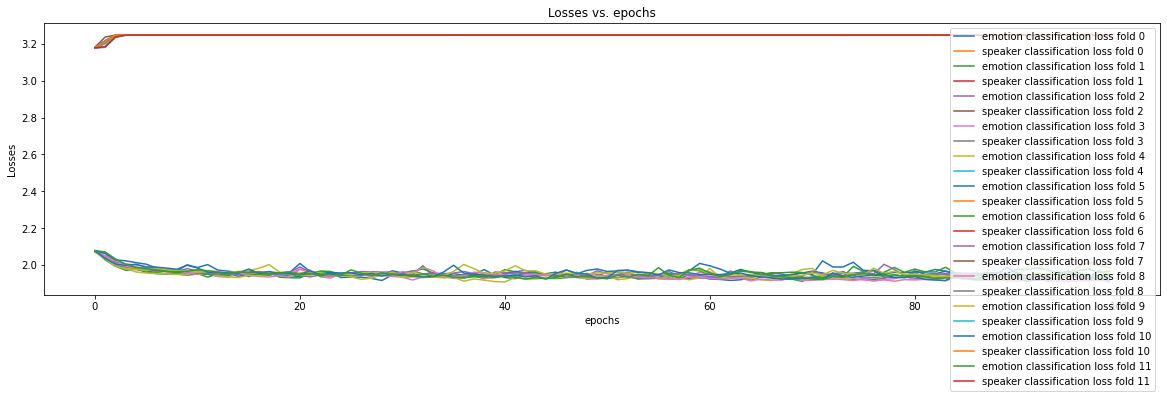

In [13]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(FOLDS):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))
    plt.plot(range(EPOCHS), fold_speaker_class_losses[i],label='speaker classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [14]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_training_accuracies[fold],label='speaker_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_validating_accuracies[fold],label='speaker_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))
    print("Maximum speaker training accuracy:{:.2f}%".format(max(fold_speaker_training_accuracies[fold])*100))
    print("Maximum speaker validating accuracy:{:.2f}%".format(max(fold_speaker_validating_accuracies[fold])*100))

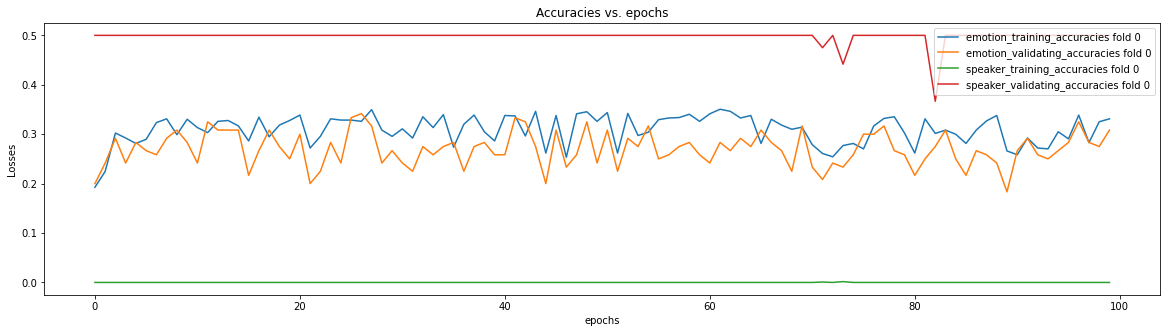

Maximum emotion training accuracy:35.05%
Maximum emotion validating accuracy:34.17%
Maximum speaker training accuracy:0.17%
Maximum speaker validating accuracy:50.00%


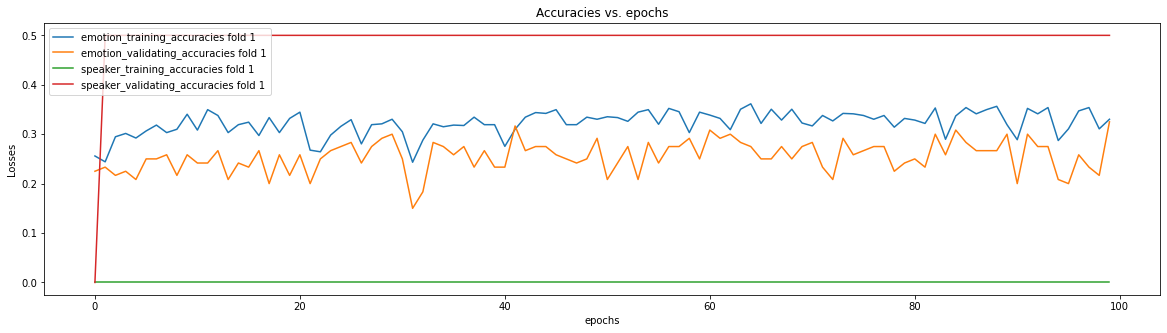

Maximum emotion training accuracy:36.15%
Maximum emotion validating accuracy:32.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


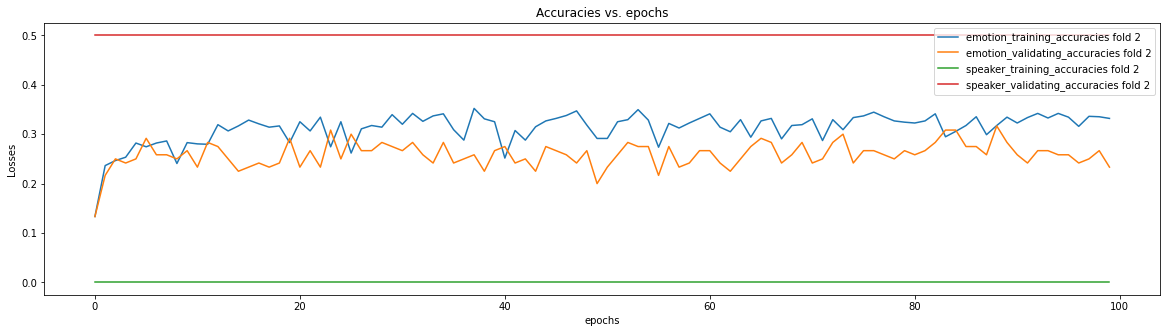

Maximum emotion training accuracy:35.22%
Maximum emotion validating accuracy:31.67%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


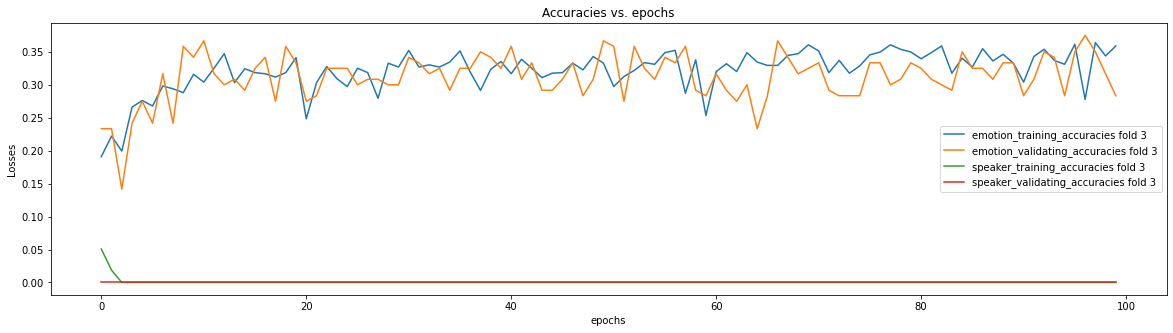

Maximum emotion training accuracy:36.40%
Maximum emotion validating accuracy:37.50%
Maximum speaker training accuracy:5.07%
Maximum speaker validating accuracy:0.00%


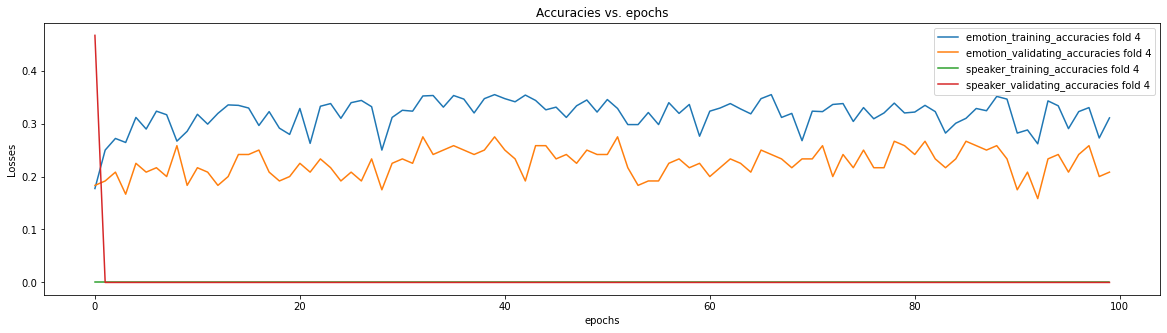

Maximum emotion training accuracy:35.47%
Maximum emotion validating accuracy:27.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:46.67%


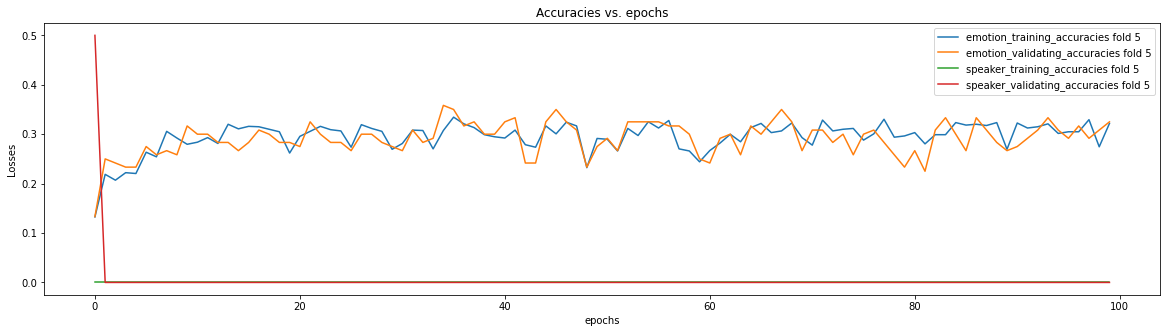

Maximum emotion training accuracy:33.45%
Maximum emotion validating accuracy:35.83%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


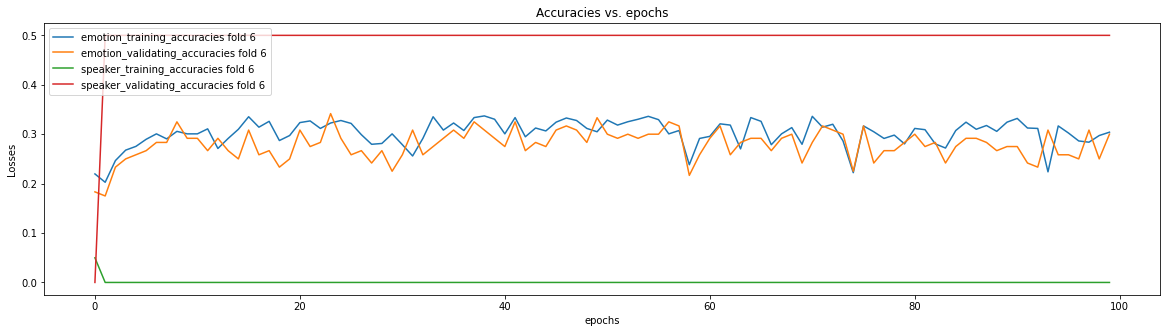

Maximum emotion training accuracy:33.70%
Maximum emotion validating accuracy:34.17%
Maximum speaker training accuracy:4.98%
Maximum speaker validating accuracy:50.00%


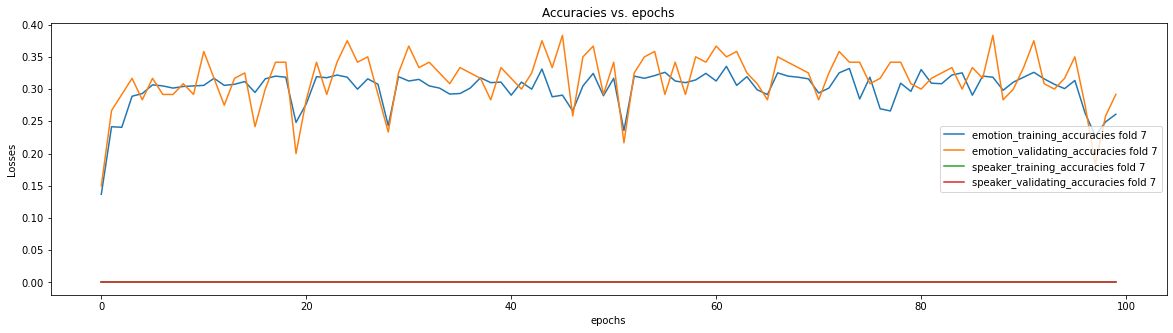

Maximum emotion training accuracy:33.53%
Maximum emotion validating accuracy:38.33%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:0.00%


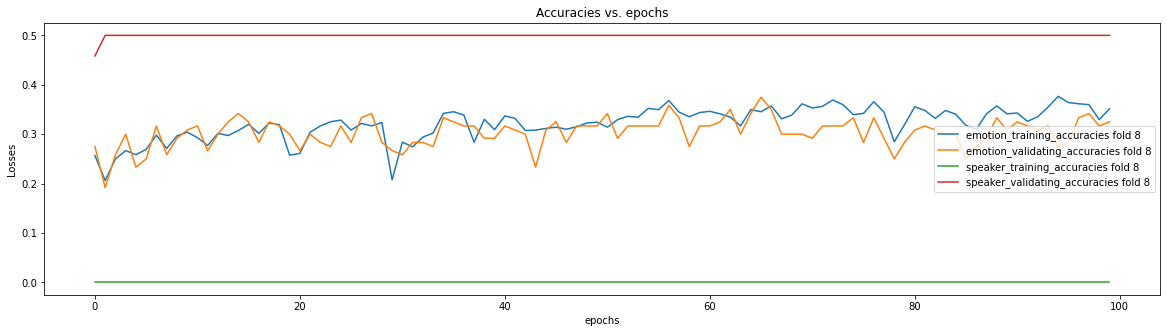

Maximum emotion training accuracy:37.67%
Maximum emotion validating accuracy:37.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


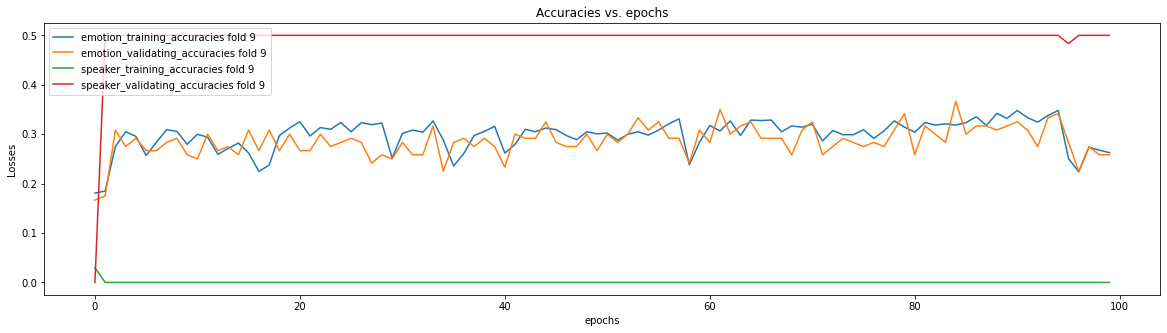

Maximum emotion training accuracy:34.80%
Maximum emotion validating accuracy:36.67%
Maximum speaker training accuracy:2.96%
Maximum speaker validating accuracy:50.00%


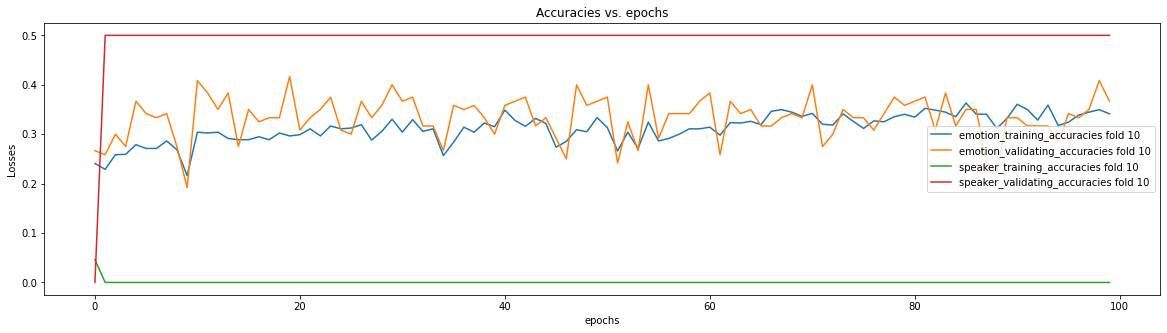

Maximum emotion training accuracy:36.32%
Maximum emotion validating accuracy:41.67%
Maximum speaker training accuracy:4.65%
Maximum speaker validating accuracy:50.00%


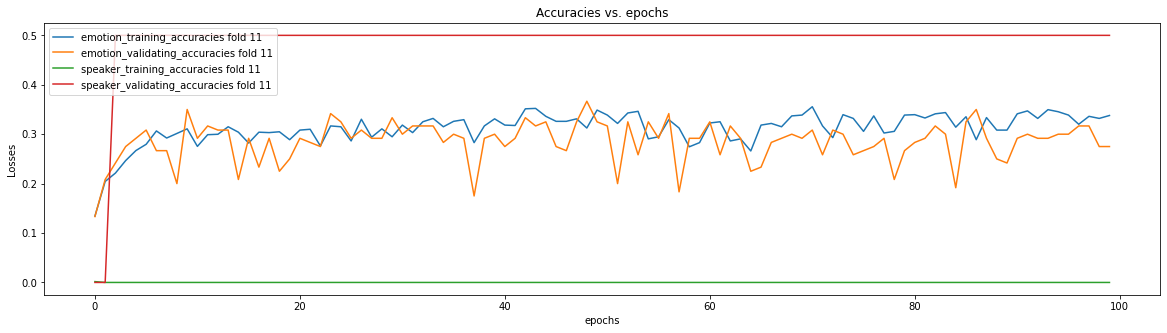

Maximum emotion training accuracy:35.56%
Maximum emotion validating accuracy:36.67%
Maximum speaker training accuracy:0.17%
Maximum speaker validating accuracy:50.00%


In [15]:
for i in range(FOLDS):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [16]:
import warnings
warnings.filterwarnings('ignore')
from statistics import mean , stdev


lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []
lfold_speaker_training_accuracies, lfold_speaker_validating_accuracies, lfold_speaker_testing_accuracies = [] , [] , []

for fold in range(12):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(ravdess_dataset_train)
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    TEST_BATCH_SIZE = len(ravdess_dataset_test)
    
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0
    lspeaker_training_correct, lspeaker_validating_correct, lspeaker_testing_correct = 0 , 0 , 0

    with torch.no_grad():
        

        # 1. Training Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
            lspeaker_training_correct += (speaker_preds == speaker).sum()
        emotion_training_accuracy = lemotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        speaker_training_accuracy = lspeaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        print("\nEmotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
        print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(lspeaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100)) 
        
        # 2. Validating Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
            lspeaker_validating_correct += (speaker_preds == speaker).sum()
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        speaker_validating_accuracy = lspeaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
        print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(lspeaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100)) 
        

        # 3. Testing Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_test_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
            lspeaker_testing_correct += (speaker_preds == speaker).sum()
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        speaker_testing_accuracy = lspeaker_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        print("\nEmotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        print("Speaker Testing Correct: {}/{} \nSpeaker Testing Accuracy: {:.5f}%".format(lspeaker_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),speaker_testing_accuracy*100)) 

        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
        lfold_speaker_training_accuracies.append(speaker_training_accuracy)
        lfold_speaker_validating_accuracies.append(speaker_validating_accuracy)
        lfold_speaker_testing_accuracies.append(speaker_testing_accuracy)

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))

print('\nCV Speaker Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_training_accuracies), stdev(lfold_speaker_training_accuracies)))
print('\nCV Speaker Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_validating_accuracies), stdev(lfold_speaker_validating_accuracies)))
print('\nCV Speaker Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_testing_accuracies), stdev(lfold_speaker_testing_accuracies)))


Evaluation for fold 0



Emotion Training Correct: 391/1200 
Emotion Training Accuracy: 32.58333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Emotion Testing Correct: 29/120 
Emotion Testing Accuracy: 24.16667%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 1



Emotion Training Correct: 395/1200 
Emotion Training Accuracy: 32.91667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 33/120 
Emotion Testing Accuracy: 27.50000%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 2



Emotion Training Correct: 381/1200 
Emotion Training Accuracy: 31.75000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 42/120 
Emotion Testing Accuracy: 35.00000%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 3



Emotion Training Correct: 332/1200 
Emotion Training Accuracy: 27.66667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 26/120 
Emotion Testing Accuracy: 21.66667%
Speaker Testing Correct: 60/120 
Speaker Testing Accuracy: 50.00000%

Evaluation for fold 4



Emotion Training Correct: 394/1200 
Emotion Training Accuracy: 32.83333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 33/120 
Emotion Testing Accuracy: 27.50000%
Speaker Testing Correct: 60/120 
Speaker Testing Accuracy: 50.00000%

Evaluation for fold 5



Emotion Training Correct: 367/1200 
Emotion Training Accuracy: 30.58333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 37/120 
Emotion Testing Accuracy: 30.83333%
Speaker Testing Correct: 60/120 
Speaker Testing Accuracy: 50.00000%

Evaluation for fold 6



Emotion Training Correct: 386/1200 
Emotion Training Accuracy: 32.16667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%


Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 42/120 
Emotion Testing Accuracy: 35.00000%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 7



Emotion Training Correct: 380/1200 
Emotion Training Accuracy: 31.66667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 42/120 
Emotion Testing Accuracy: 35.00000%
Speaker Testing Correct: 60/120 
Speaker Testing Accuracy: 50.00000%

Evaluation for fold 8



Emotion Training Correct: 411/1200 
Emotion Training Accuracy: 34.25000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 41/120 
Emotion Testing Accuracy: 34.16667%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 9



Emotion Training Correct: 378/1200 
Emotion Training Accuracy: 31.50000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Emotion Testing Correct: 42/120 
Emotion Testing Accuracy: 35.00000%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 10



Emotion Training Correct: 357/1200 
Emotion Training Accuracy: 29.75000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 37/120 
Emotion Testing Accuracy: 30.83333%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 11



Emotion Training Correct: 373/1200 
Emotion Training Accuracy: 31.08333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 35/120 
Emotion Testing Accuracy: 29.16667%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

SUMMARY:

CV Emotion Training accuracies 
Mean: 0.315625 
S.D: 0.016997195995727406

CV Emotion Validating accuracies 
Mean: 0.35347222222222224 
S.D: 0.03666293599019145

CV Emotion Testing accuracies 
Mean: 0.30486111111111114 
S.D: 0.04598231068164033

CV Speaker Training accuracies 
Mean: 0.0 
S.D: 0.0

CV Speaker Validating accuracies 
Mean: 0.3333333333333333 
S.D: 0.24618298195866548

CV Speaker Testing accuracies 
Mean: 0.16666666666666666 
S.D: 0.24618298195866548
